In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
import multipoles
import ellisbaldwin
from qso_sample import QSOSample
import dipole

### load samples

In [3]:
# instantiate dipole object:
catdir = '/scratch/aew492/quasars/catalogs'
mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')

d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d.cut_mag()  # cuts all sources fainter than maglim from the working source table
d.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table (based on healpixel mask)

# load selection function
selfunc_quaia = d.get_selfunc(os.path.join(catdir, 'quaia/selfuncs',
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_blim15.fits')) # note the blim15 !
# overdensity map, corrected by selection function
overdensity_map_quaia = d.construct_overdensity_map(selfunc=selfunc_quaia)

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut G > 20.0 -> 755850 sources left.
cut |b| <= 30 based on healpix mask -> 530559 sources left.
constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


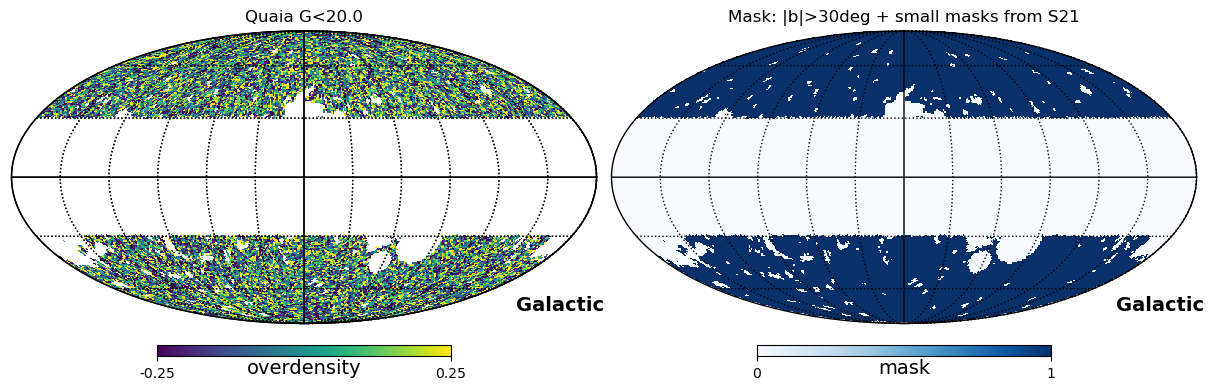

In [4]:
# plot overdensity map and mask
fig = plt.figure(figsize=(12,4))
hp.mollview(overdensity_map_quaia, coord=['C','G'], min=-0.25, max=0.25, unit='overdensity', title=f'Quaia G<{d.maglim}', badcolor='w',
            fig=fig, sub=(1,2,1))
hp.graticule()
hp.mollview(d.mask, coord=['C','G'], min=0, max=1, unit='mask', title=f'Mask: |b|>{d.blim}deg + small masks from S21',
            cmap='Blues', fig=fig, sub=(1,2,2))
hp.graticule()

In [5]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              blim=30)
d.cut_mag()  # cuts all sources fainter than maglim from the working source table
d.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# load selection function
selfunc_catwise = d.get_selfunc(os.path.join(catdir, 'catwise_agns/selfuncs',
                                            f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))
# overdensity map, corrected by selection function
overdensity_map_catwise = d.construct_overdensity_map(selfunc=selfunc_catwise)

loading initial catalog, /scratch/aew492/quasars/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut W1 > 16.4 -> 3079981 sources left.
cut |b| <= 30 based on healpix mask -> 1400868 sources left.
constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


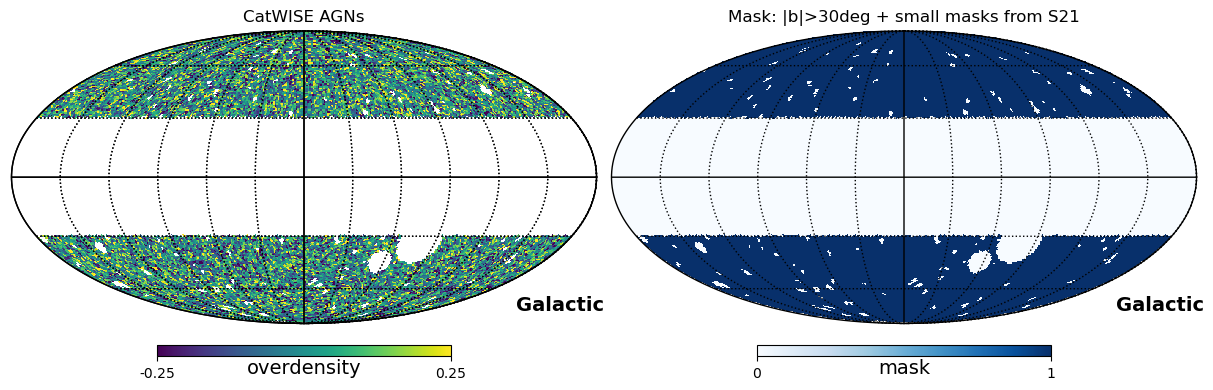

In [6]:
# plot overdensity map and mask
fig = plt.figure(figsize=(12,4))
hp.mollview(overdensity_map_catwise, coord=['C','G'], min=-0.25, max=0.25, unit='overdensity', title=f'CatWISE AGNs', badcolor='w',
            fig=fig, sub=(1,2,1))
hp.graticule()
hp.mollview(d.mask, coord=['C','G'], min=0, max=1, unit='mask', title=f'Mask: |b|>{d.blim}deg + small masks from S21',
            cmap='Blues', fig=fig, sub=(1,2,2))
hp.graticule()

### noise-matched regularization

In [7]:
max_ells = np.arange(1, 11).astype(int)

#### CatWISE

CatWISE AGNs, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq
mean density = 72.19 quasars per healpixel


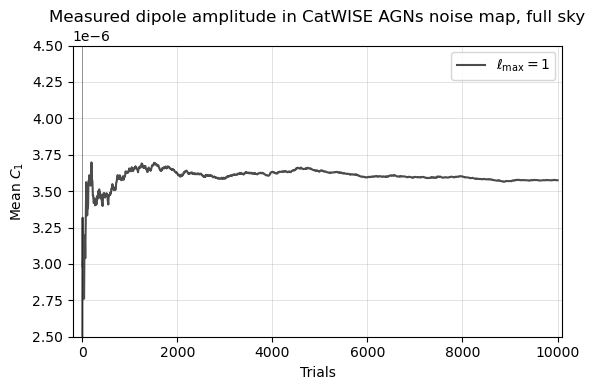

In [8]:
# load dipole amplitudes measured on full sky Poisson noise with CatWISE mean quasar density
res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax1_10000trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells_fullsky']
ntrialss = res['ntrials']
mu = res['mu']
print(res['comment']+f'\nmean density = {mu:.2f} quasars per healpixel')

# plot convergence
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(ntrialss, Cells1[:,0], 'k-', alpha=0.7, label=r'$\ell_\mathrm{max}=1$', zorder=10)
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(2.5e-6, 4.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in CatWISE AGNs noise map, full sky')
ax.legend()

In [9]:
# take the full sky shot noise dipole to be the mean C1 of these trials
C1_fullsky_catwise = Cells1.flatten()[-1]
C1_fullsky_catwise

3.574566708272148e-06

In [10]:
# load the results on the CUT sky (C1 as a function of Lambda), interpolate,
#  and save the Lambda where the cut sky curve intersects the full sky noise dipole
cutsky_res = []
Lambdas_catwise_noise_matched = np.empty(len(max_ells))
for i, max_ell in enumerate(max_ells):
    # load the cut sky results
    res_cut = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_cutsky_ellmax{max_ell}_500trials_Lambda.npy',
                      allow_pickle=True).item()
    Lambdas, Cells_cut, stds = list(zip(*res_cut['Cells_cutsky']))
    # sort in order of increasing Lambda (these were run with multiprocessing so might have been saved in a weird order)
    idx_sorted = np.array(Lambdas).argsort()
    Lambdas, C1s_cut = np.array(Lambdas)[idx_sorted], np.array(Cells_cut)[idx_sorted][:,0] # to get C_1 only
    stds = np.array(stds)[idx_sorted][:,0] # standard deviation of the trials
    cutsky_res.append(np.array([Lambdas, C1s_cut, stds]))
    
    # interpolate on a finer grid
    Lambdas_fine = np.logspace(np.log10(min(Lambdas)), np.log10(max(Lambdas)), 10001)
    C1s_cut_fine = np.interp(Lambdas_fine, Lambdas, C1s_cut)
    # find closest Lambda in the interpolated list to the C_1 on the full sky
    idx_closest = np.abs(C1s_cut_fine - C1_fullsky_catwise).argmin()
    Lambdas_catwise_noise_matched[i] = Lambdas_fine[idx_closest]

Text(0.5, 1.0, 'CatWISE AGNs measured shot noise dipole vs. regularization')

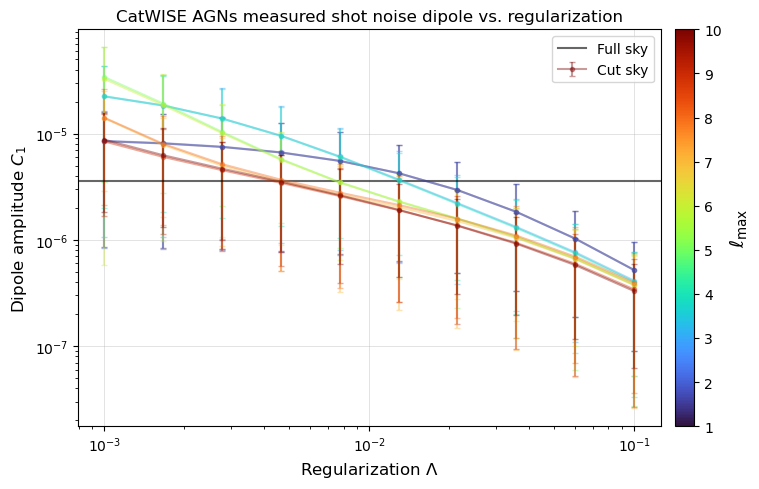

In [11]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, max_ell in enumerate(max_ells):
    Lambdas, C1s_cut, stds = cutsky_res[i]
    label = 'Cut sky' if i==max(max_ells)-1 else ''
    ax.errorbar(Lambdas, C1s_cut, yerr=stds, capsize=2, marker='.', c=smap.to_rgba(max_ell), alpha=0.4, label=label)
ax.axhline(C1_fullsky_catwise, c='k', alpha=0.6, label='Full sky')
ax.grid(alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_ylabel(r'Dipole amplitude $C_1$', fontsize=12)
cbar = fig.colorbar(smap, ax=ax, ticks=max_ells.astype(int), pad=.02)
cbar.set_label(label=r'$\ell_\mathrm{max}$', fontsize=14)
ax.legend()
ax.set_title('CatWISE AGNs measured shot noise dipole vs. regularization')

In [12]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_catwise_noise_matched))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_catwise_noise-matched.npy'
np.save(save_fn, res)

#### Quaia

Quaia G<20.0, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq
mean density = 33.50 quasars per healpixel


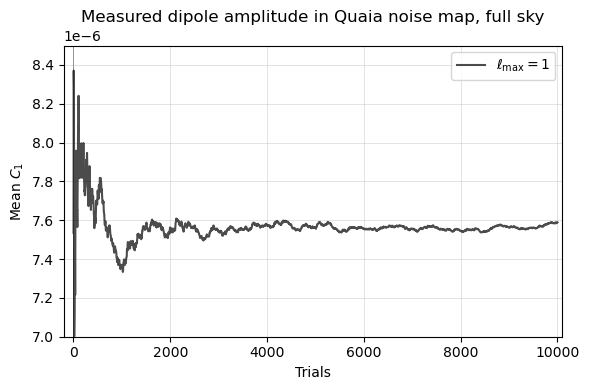

In [13]:
# noise on the full sky
res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax1_10000trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells_fullsky']
ntrialss = res['ntrials']
mu = res['mu']
print(res['comment']+f'\nmean density = {mu:.2f} quasars per healpixel')

# plot convergence
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(ntrialss, Cells1[:,0], 'k-', alpha=0.7, label=r'$\ell_\mathrm{max}=1$', zorder=10)
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(7e-6, 8.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in Quaia noise map, full sky')
ax.legend()

In [14]:
# take the full sky shot noise dipole to be the mean C1 of these trials
C1_fullsky_quaia = Cells1.flatten()[-1]
C1_fullsky_quaia

7.5888254789316214e-06

In [15]:
# load the results on the CUT sky (C1 as a function of Lambda), interpolate,
#  and save the Lambda where the cut sky curve intersects the full sky noise dipole
cutsky_res = []
Lambdas_quaia_noise_matched = np.empty(len(max_ells))
for i, max_ell in enumerate(max_ells):
    res_cut = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_cutsky_ellmax{max_ell}_500trials_Lambda.npy',
                      allow_pickle=True).item()
    Lambdas, Cells_cut, stds = list(zip(*res_cut['Cells_cutsky']))
    idx_sorted = np.array(Lambdas).argsort()
    Lambdas, C1s_cut = np.array(Lambdas)[idx_sorted], np.array(Cells_cut)[idx_sorted][:,0] # to get C_1 only
    stds = np.array(stds)[idx_sorted][:,0] # standard deviation of the trials
    cutsky_res.append(np.array([Lambdas, C1s_cut, stds]))
    
    # interpolate on a finer grid
    Lambdas_fine = np.logspace(np.log10(min(Lambdas)), np.log10(max(Lambdas)), 10001)
    C1s_cut_fine = np.interp(Lambdas_fine, Lambdas, C1s_cut)
    # find closest Lambda in the interpolated list to the C_1 on the full sky
    idx_closest = np.abs(C1s_cut_fine - C1_fullsky_quaia).argmin()
    Lambdas_quaia_noise_matched[i] = Lambdas_fine[idx_closest]

Text(0.5, 1.0, 'Quaia G<20.0 measured shot noise dipole vs. regularization')

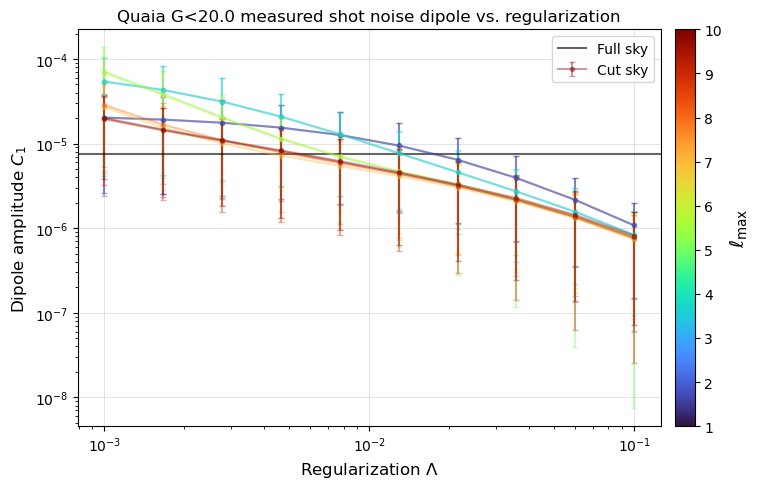

In [16]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, max_ell in enumerate(max_ells):
    Lambdas, C1s_cut, stds = cutsky_res[i]
    label = 'Cut sky' if i==max(max_ells)-1 else ''
    ax.errorbar(Lambdas, C1s_cut, yerr=stds, capsize=2, marker='.', c=smap.to_rgba(max_ell), alpha=0.4, label=label)
ax.axhline(C1_fullsky_quaia, c='k', alpha=0.6, label='Full sky')
ax.grid(alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_ylabel(r'Dipole amplitude $C_1$', fontsize=12)
cbar = fig.colorbar(smap, ax=ax, ticks=max_ells.astype(int), pad=.02)
cbar.set_label(label=r'$\ell_\mathrm{max}$', fontsize=14)
ax.legend()
ax.set_title('Quaia G<20.0 measured shot noise dipole vs. regularization')

In [17]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_quaia_noise_matched))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_quaia_noise-matched.npy'
np.save(save_fn, res)

#### compare

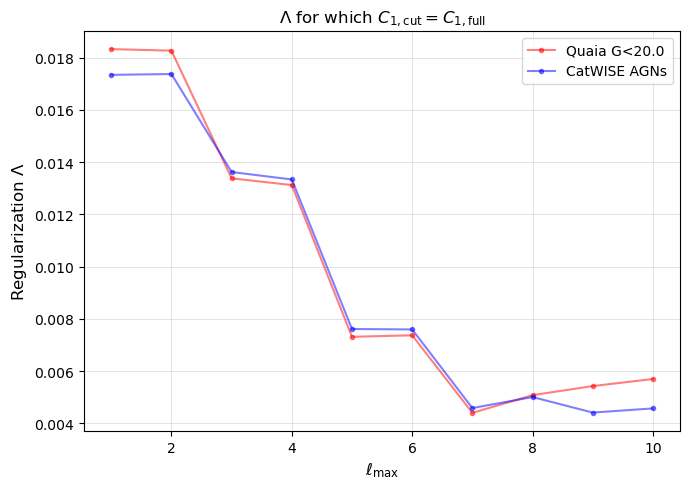

In [18]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_quaia_noise_matched, c='r', alpha=0.5, marker='.', label='Quaia G<20.0')
ax.plot(max_ells, Lambdas_catwise_noise_matched, c='b', alpha=0.5, marker='.', label='CatWISE AGNs')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'$\Lambda$ for which $C_{1,\mathrm{cut}} = C_{1,\mathrm{full}}$')
ax.legend()

### variance-matched

variance in the reconstructed maps, from spherical harmonics fit with different regularization strengths $\Lambda$

In [43]:
max_ells = np.arange(2, 11).astype(int)

#### Quaia

curves for max_ell=3 intersect 2 times!


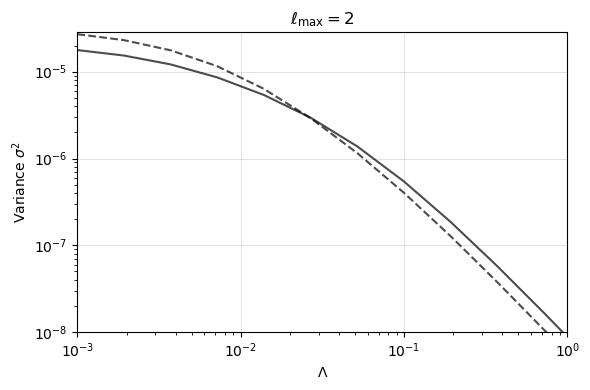

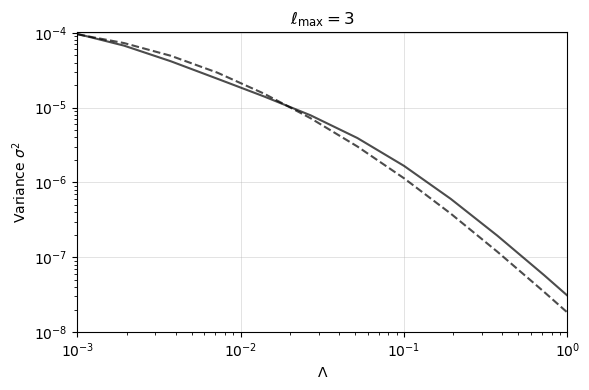

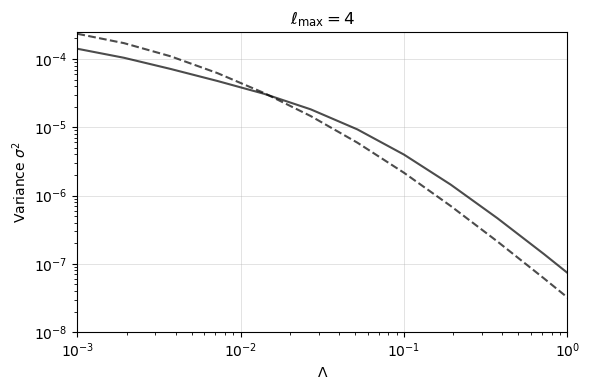

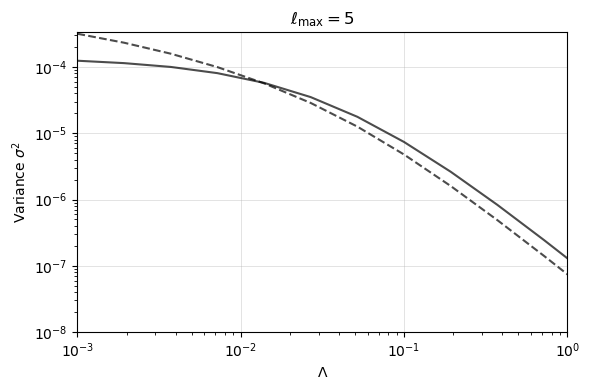

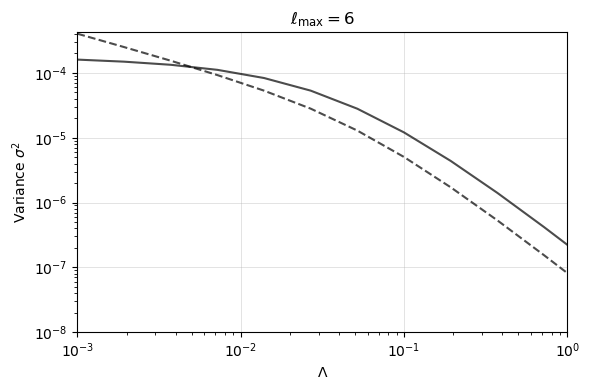

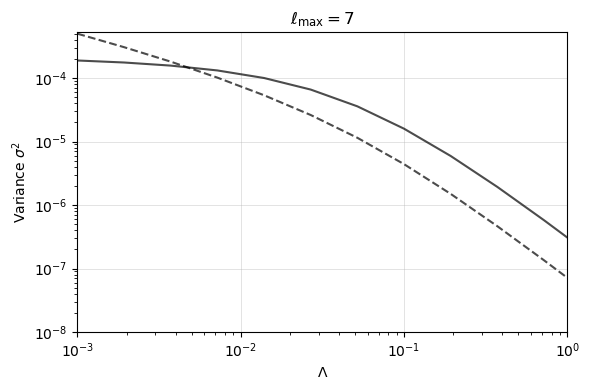

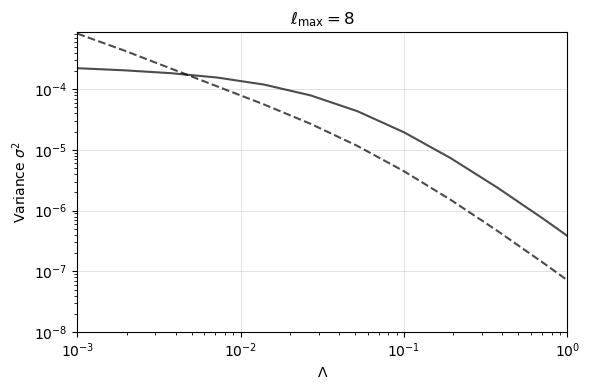

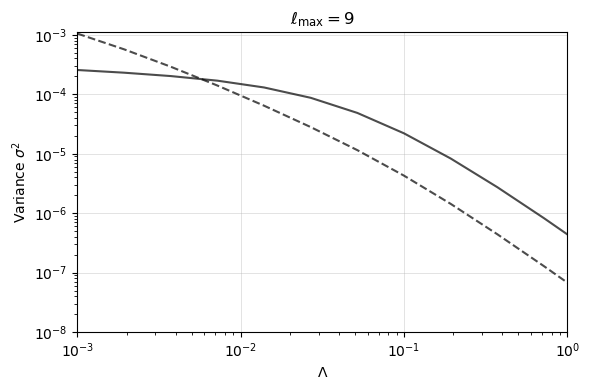

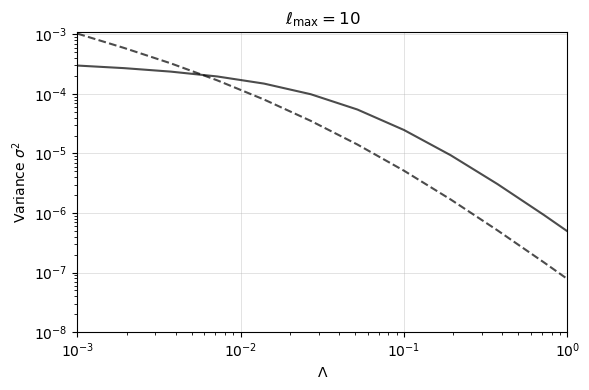

In [20]:
# load results
Lambdas = []
var_unmasked = []
var_masked = []
reconstructed_maps_wo_dipole = []
Lambdas_quaia_var_matched = np.empty(len(max_ells))

for i, max_ell in enumerate(max_ells):
    # load results
    res = np.load(f'/scratch/aew492/quasars/regularization/variance_quaia_ellmax{max_ell}.npy', allow_pickle=True).item()
    Lambdas_ = res['Lambdas']
    var_unmasked_ = res['var_unmasked']
    var_masked_ = res['var_masked']

    # find intersection point (technically where the difference of the interpolated curves changes signs
    Lambdas_fine = np.logspace(np.log10(min(Lambdas_)), np.log10(max(Lambdas_)), 10001)
    var_unmasked_interp = np.interp(Lambdas_fine, Lambdas_, var_unmasked_)
    var_masked_interp = np.interp(Lambdas_fine, Lambdas_, var_masked_)
    iintersect = np.argwhere(np.diff(np.sign(var_unmasked_interp - var_masked_interp))).flatten()
    if len(iintersect) > 1:
        print(f"curves for max_ell={max_ell} intersect {len(iintersect)} times!")
    Lambdas_quaia_var_matched[i] = Lambdas_fine[iintersect[-1]]  # pull the highest Lambda

    # plot
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    ax.plot(res['Lambdas'], res['var_unmasked'], c='k', alpha=0.7)
    ax.plot(res['Lambdas'], res['var_masked'], c='k', ls='--', alpha=0.7)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(1e-3, 1e0)
    ax.set_ylim(1e-8,None)
    ax.loglog()
    ax.set_xlabel(r'$\Lambda$')
    ax.set_ylabel(r'Variance $\sigma^2$')
    ax.set_title(r'$\ell_\mathrm{max}=$'f'{max_ell}')

    # append
    Lambdas.append(res['Lambdas'])
    var_unmasked.append(res['var_unmasked'])
    var_masked.append(res['var_masked'])
    # overdensity_map = res['overdensity_map']
    reconstructed_maps_wo_dipole.append(res['reconstructed_maps_wo_dipole'])

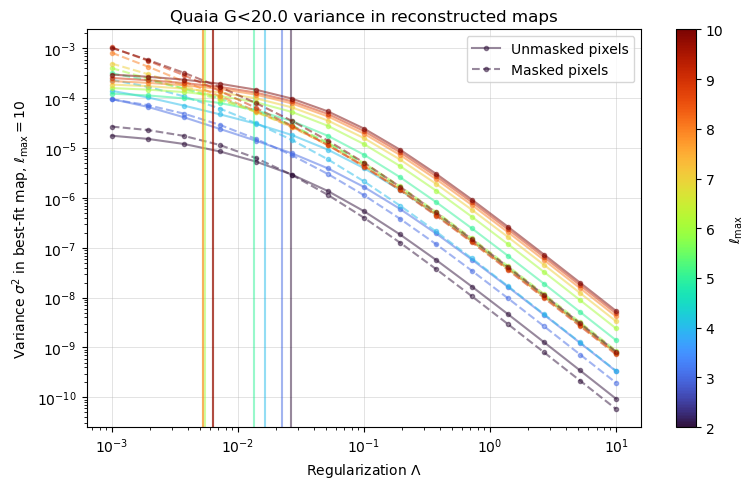

In [23]:
# plot
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
for i, max_ell in enumerate(max_ells):
    kwargs = dict(marker='.', c=smap.to_rgba(max_ell), alpha=0.5)
    label = 'Unmasked pixels' if i==0 else ''
    ax.plot(Lambdas[i], var_unmasked[i], label=label, **kwargs)
    label = 'Masked pixels' if i==0 else ''
    ax.plot(Lambdas[i], var_masked[i], label=label, ls='--', **kwargs)
    ax.axvline(Lambdas_quaia_var_matched[i], c=smap.to_rgba(max_ell), alpha=0.5) # the Lambda we've saved as the intersection point
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'Variance $\sigma^2$ in best-fit map, $\ell_\mathrm{max}=$'f'{max_ell}')
ax.legend()
ax.set_title(f'Quaia G<20.0 variance in reconstructed maps')
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$')

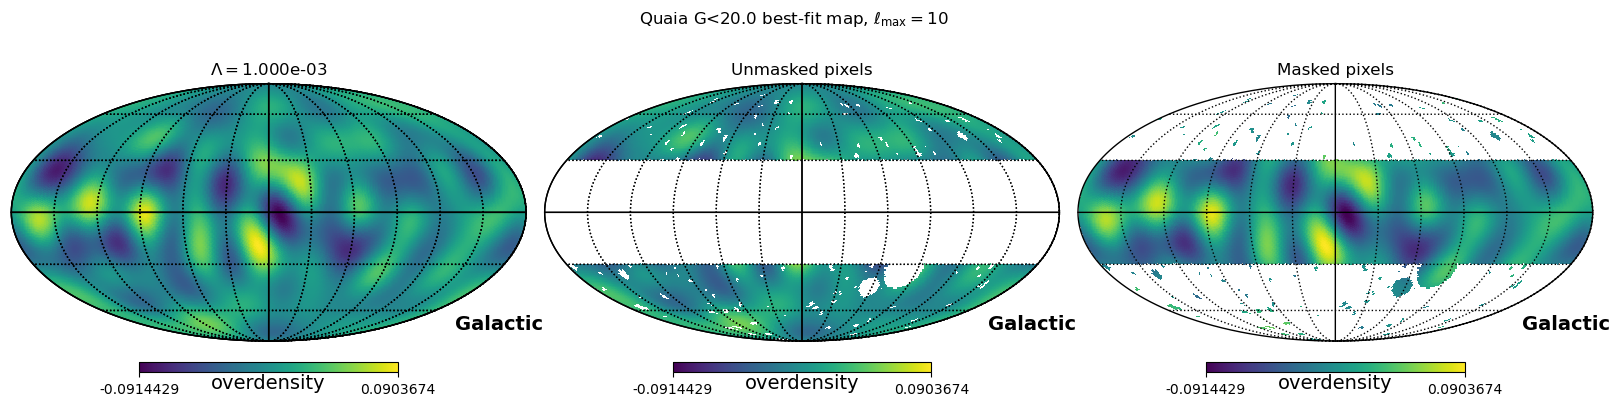

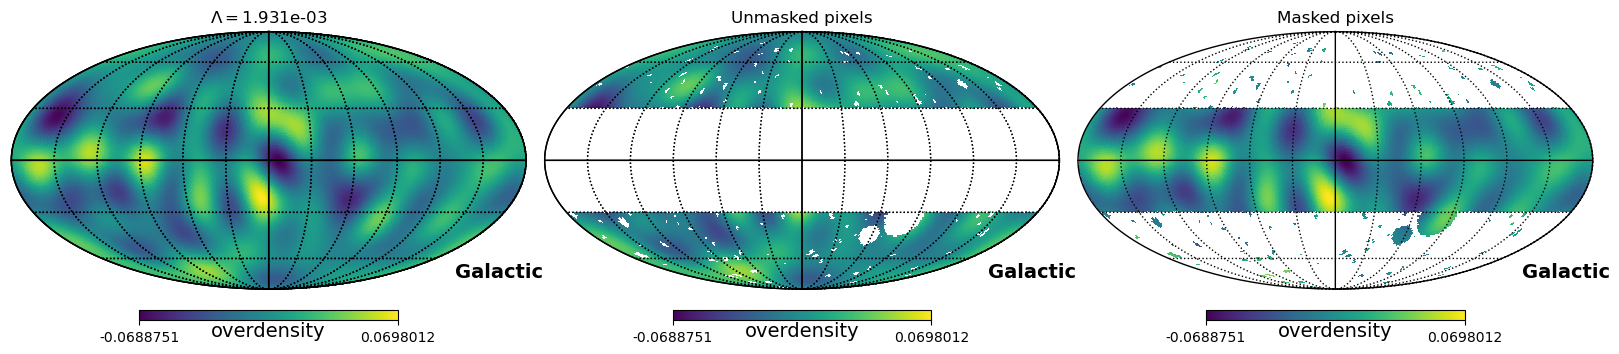

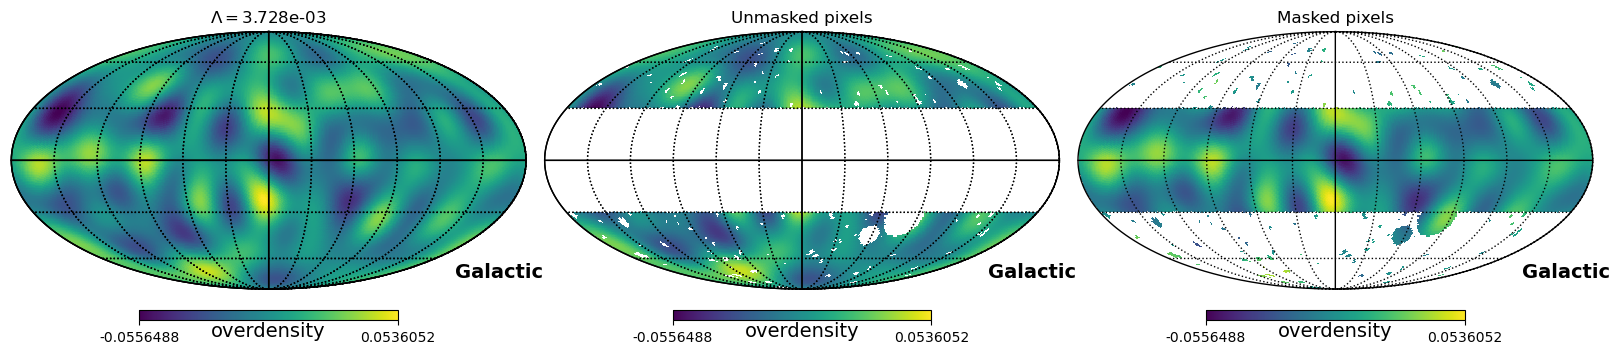

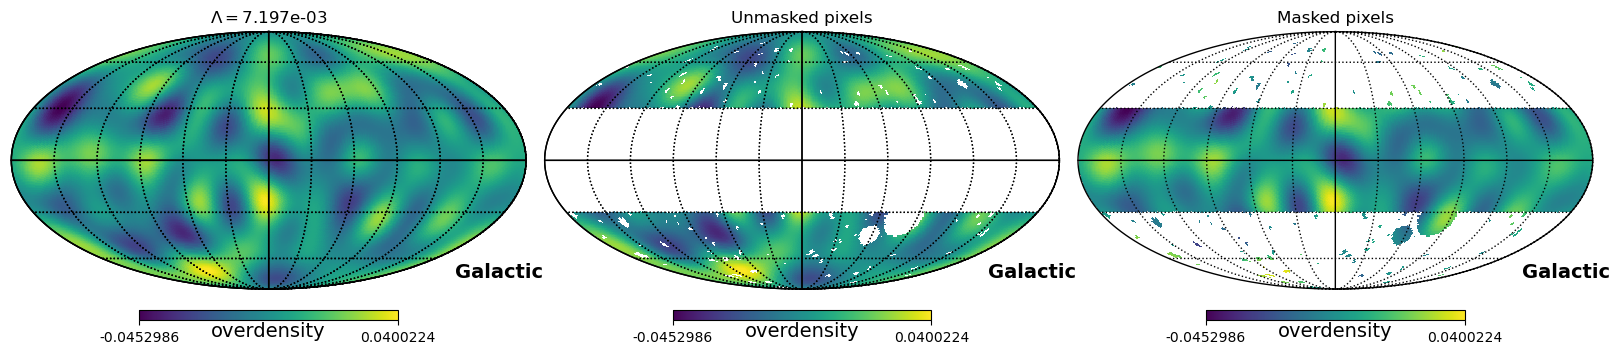

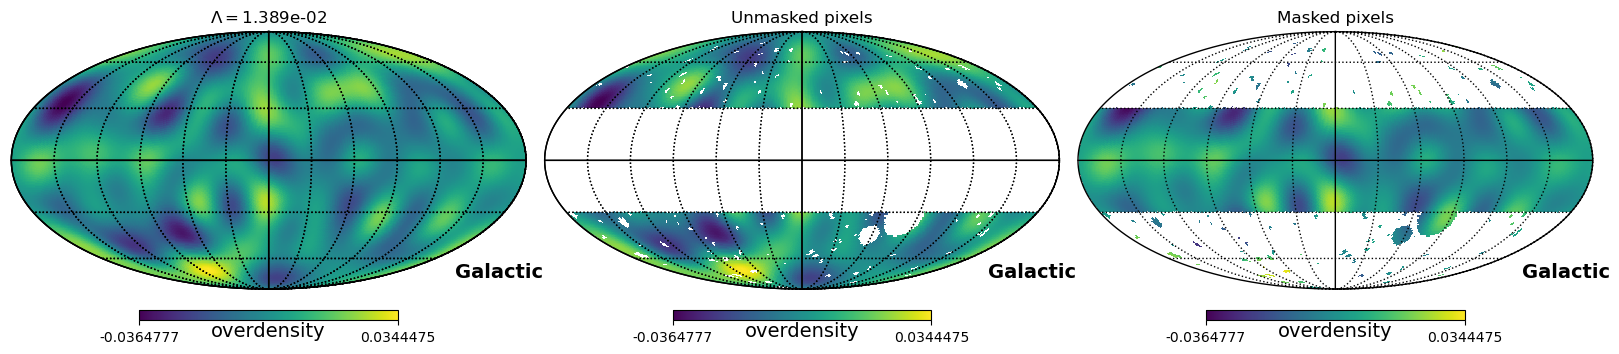

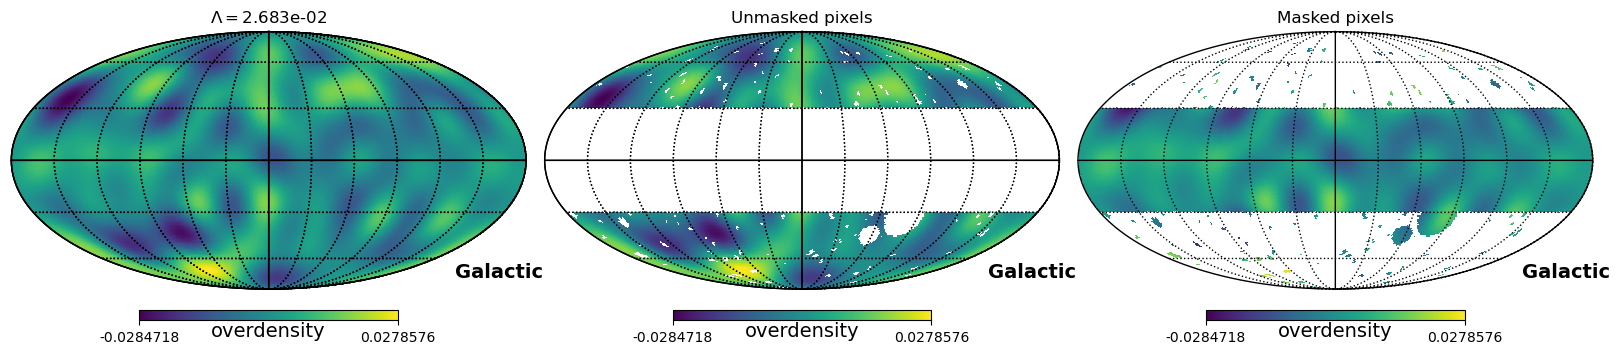

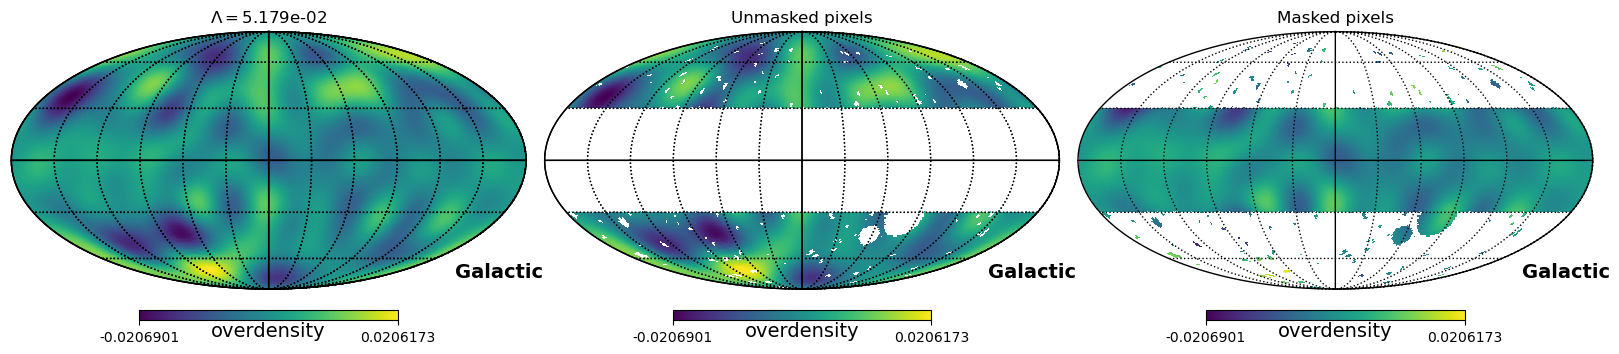

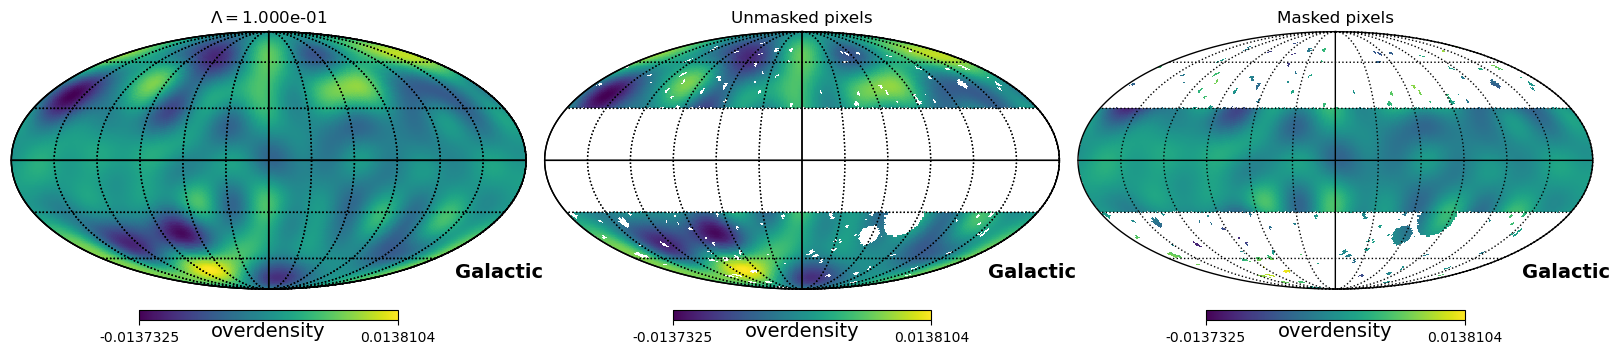

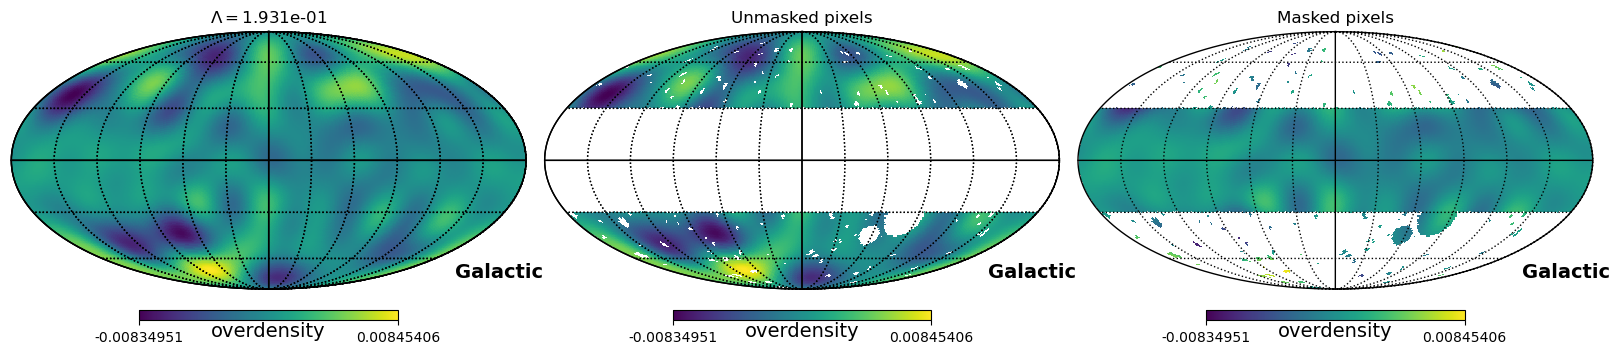

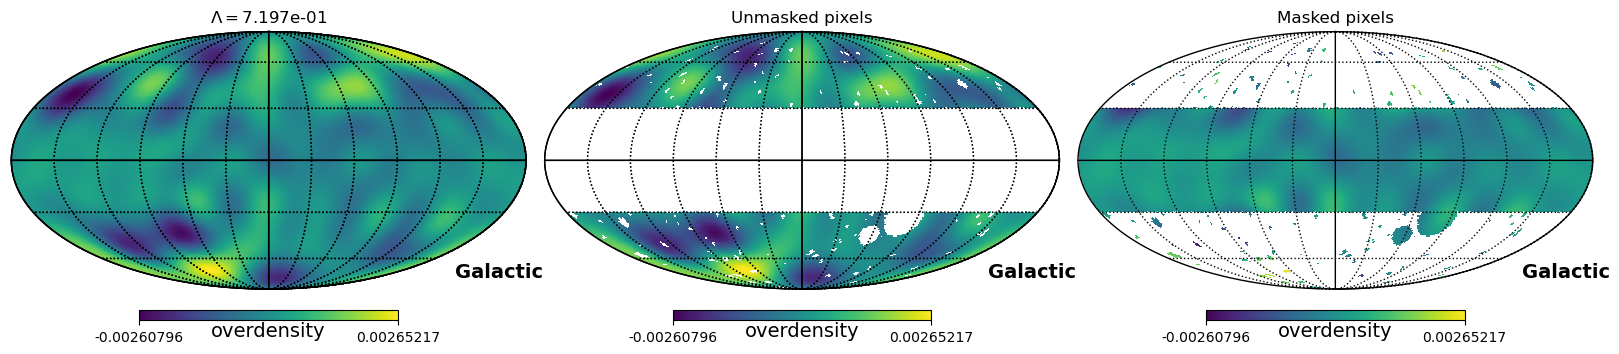

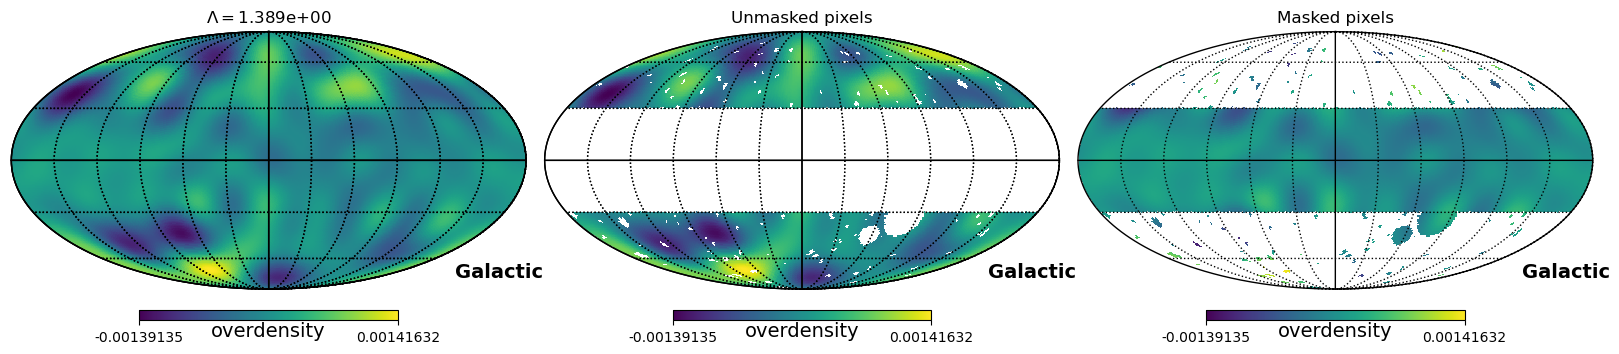

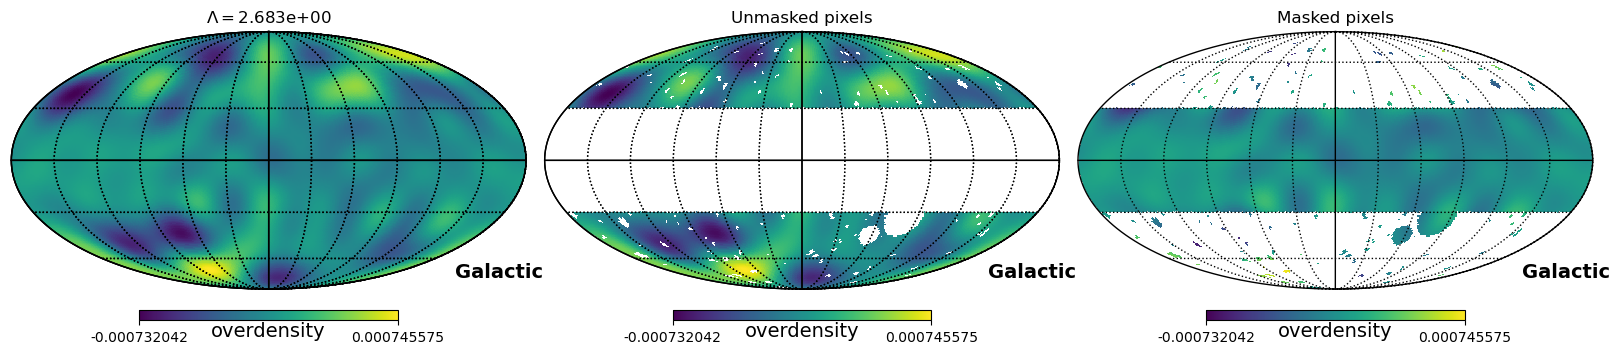

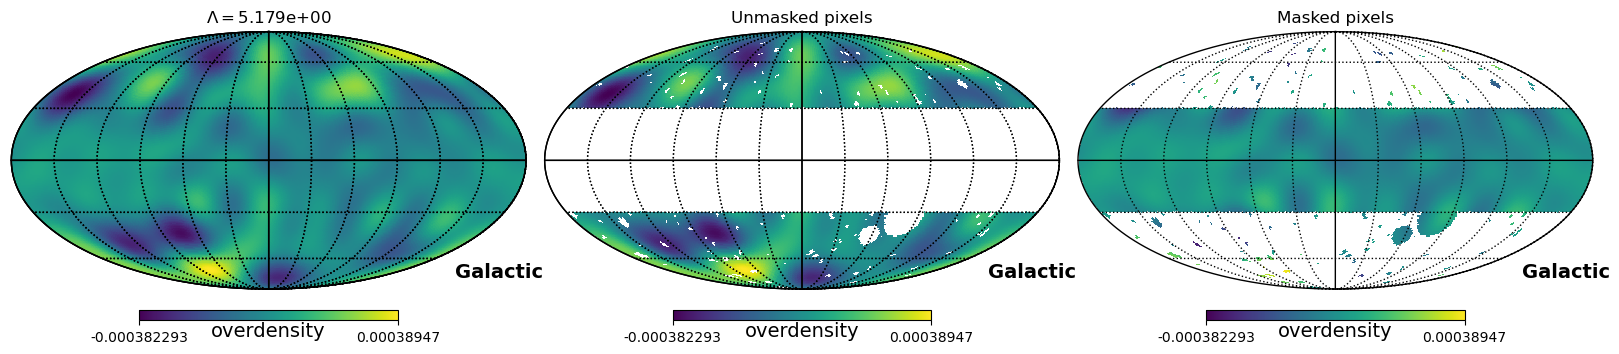

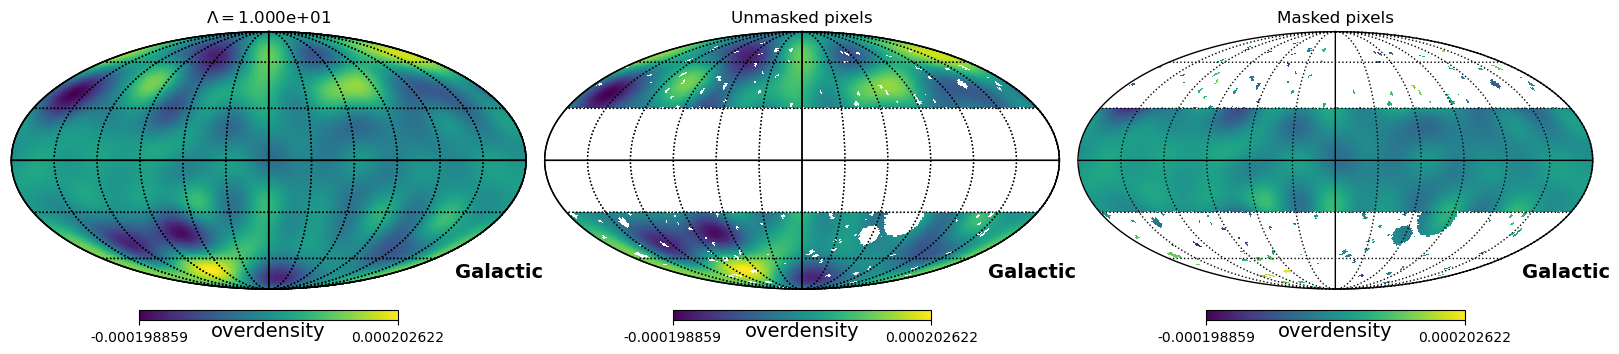

In [22]:
# plot the reconstructed maps from the last max ell: each row is a different Lambda
for i, reconstructed_map in enumerate(res['reconstructed_maps_wo_dipole']):
    fig = plt.figure(figsize=(16,4))
    kwargs = dict(coord=['C','G'], unit='overdensity', badcolor='w', fig=fig, 
                  min=np.nanmin(reconstructed_map), max=np.nanmax(reconstructed_map))
    hp.mollview(reconstructed_map, title=r'$\Lambda=$'f'{Lambdas[-1][i]:.3e}', sub=(1,3,1), **kwargs)
    hp.graticule()
    unmasked_pix = reconstructed_map.copy()
    unmasked_pix[~d.mask] = np.nan
    hp.mollview(unmasked_pix, title=f'Unmasked pixels', sub=(1,3,2), **kwargs)
    hp.graticule()
    masked_pix = reconstructed_map.copy()
    masked_pix[d.mask] = np.nan
    hp.mollview(masked_pix, title=f'Masked pixels', sub=(1,3,3), **kwargs)
    hp.graticule()
    if i==0:
        fig.suptitle(f'Quaia G<20.0 best-fit map, 'r'$\ell_\mathrm{max}=$'f'{max_ells[-1]}')

In [24]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_quaia_var_matched))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_quaia_variance-matched.npy'
np.save(save_fn, res)

#### CatWISE

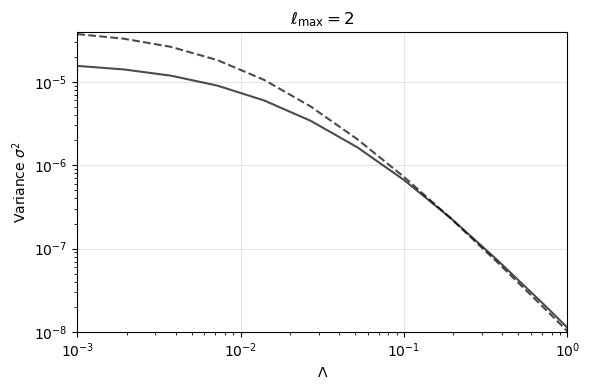

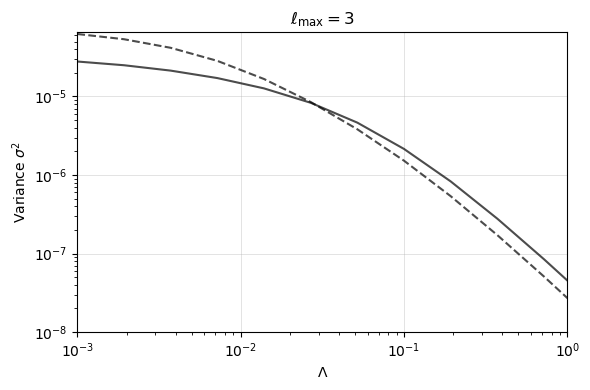

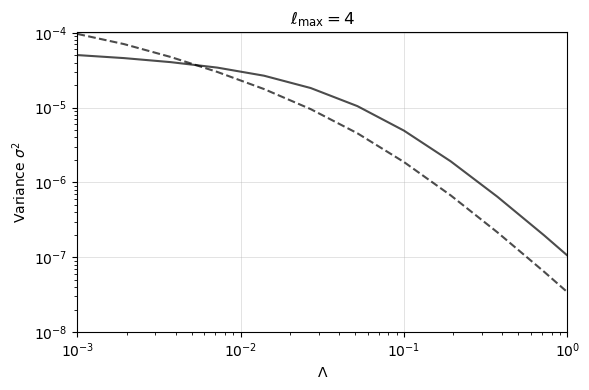

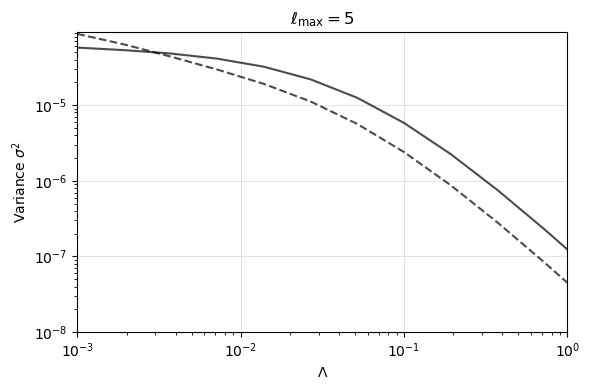

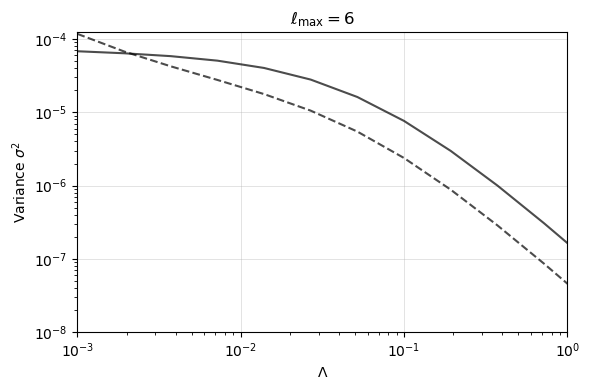

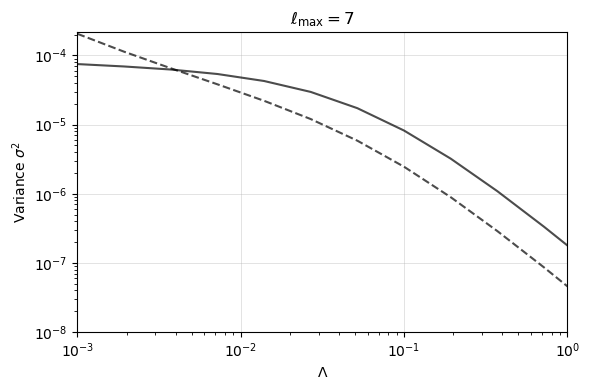

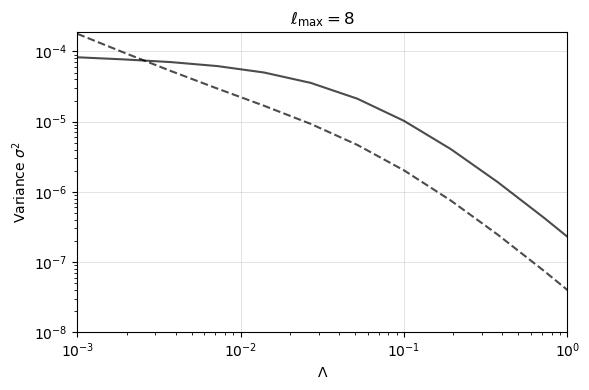

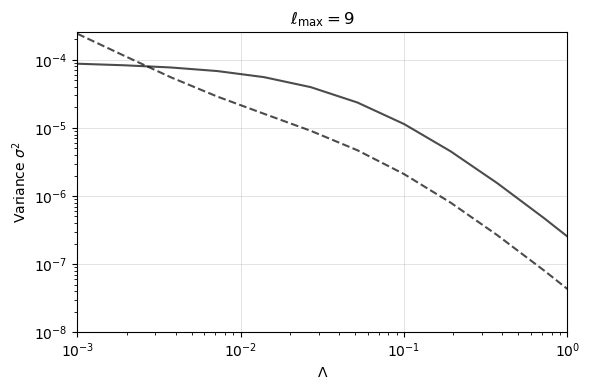

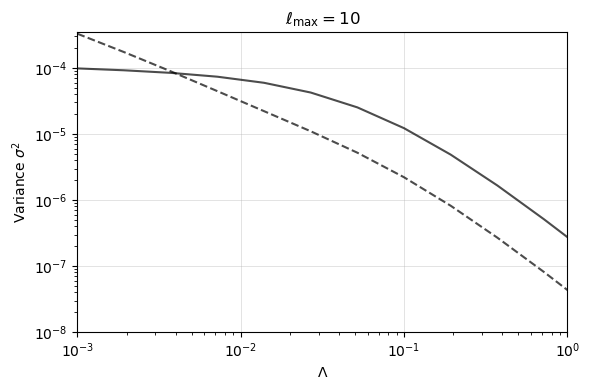

In [25]:
# load results
Lambdas = []
var_unmasked = []
var_masked = []
reconstructed_maps_wo_dipole = []
Lambdas_catwise_var_matched = np.empty(len(max_ells))

for i, max_ell in enumerate(max_ells):
    # load results
    res = np.load(f'/scratch/aew492/quasars/regularization/variance_catwise_agns_ellmax{max_ell}.npy', allow_pickle=True).item()
    Lambdas_ = res['Lambdas']
    var_unmasked_ = res['var_unmasked']
    var_masked_ = res['var_masked']

    # find intersection point (technically where the difference of the interpolated curves changes signs
    Lambdas_fine = np.logspace(np.log10(min(Lambdas_)), np.log10(max(Lambdas_)), 10001)
    var_unmasked_interp = np.interp(Lambdas_fine, Lambdas_, var_unmasked_)
    var_masked_interp = np.interp(Lambdas_fine, Lambdas_, var_masked_)
    iintersect = np.argwhere(np.diff(np.sign(var_unmasked_interp - var_masked_interp))).flatten()
    if len(iintersect) > 1:
        print(f"curves for max_ell={max_ell} intersect {len(iintersect)} times!")
    Lambdas_catwise_var_matched[i] = Lambdas_fine[iintersect[-1]]  # pull the highest Lambda

    # plot
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    ax.plot(res['Lambdas'], res['var_unmasked'], c='k', alpha=0.7)
    ax.plot(res['Lambdas'], res['var_masked'], c='k', ls='--', alpha=0.7)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(1e-3, 1e0)
    ax.set_ylim(1e-8,None)
    ax.loglog()
    ax.set_xlabel(r'$\Lambda$')
    ax.set_ylabel(r'Variance $\sigma^2$')
    ax.set_title(r'$\ell_\mathrm{max}=$'f'{max_ell}')

    # append
    Lambdas.append(res['Lambdas'])
    var_unmasked.append(res['var_unmasked'])
    var_masked.append(res['var_masked'])
    # overdensity_map = res['overdensity_map']
    reconstructed_maps_wo_dipole.append(res['reconstructed_maps_wo_dipole'])

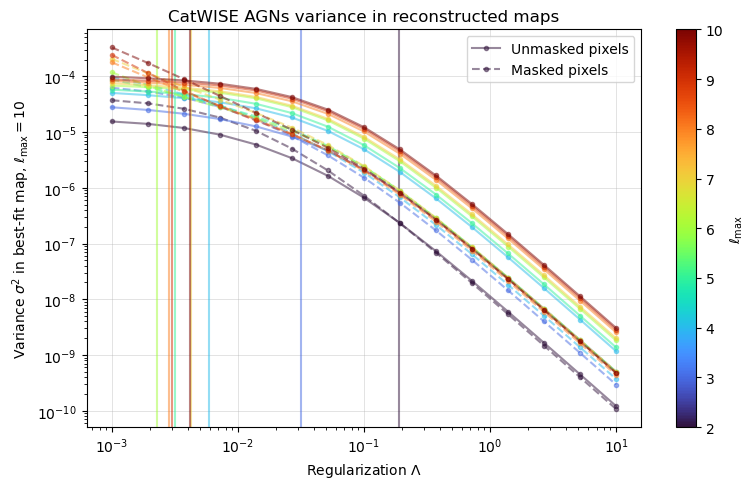

In [26]:
# plot
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
for i, max_ell in enumerate(max_ells):
    kwargs = dict(marker='.', c=smap.to_rgba(max_ell), alpha=0.5)
    label = 'Unmasked pixels' if i==0 else ''
    ax.plot(Lambdas[i], var_unmasked[i], label=label, **kwargs)
    label = 'Masked pixels' if i==0 else ''
    ax.plot(Lambdas[i], var_masked[i], label=label, ls='--', **kwargs)
    ax.axvline(Lambdas_catwise_var_matched[i], c=smap.to_rgba(max_ell), alpha=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$')
ax.set_ylabel(r'Variance $\sigma^2$ in best-fit map, $\ell_\mathrm{max}=$'f'{max_ell}')
ax.legend()
ax.set_title(f'CatWISE AGNs variance in reconstructed maps')
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$')

In [27]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_catwise_var_matched))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_catwise_variance-matched.npy'
np.save(save_fn, res)

#### compare

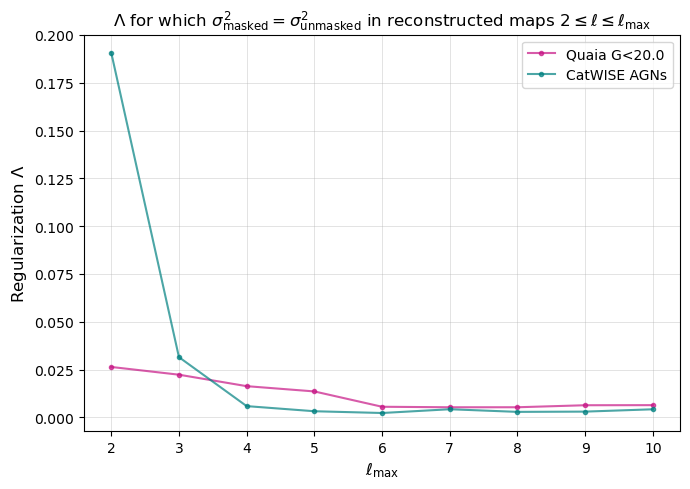

In [45]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_quaia_var_matched, c='mediumvioletred', alpha=0.7, marker='.', label='Quaia G<20.0')
ax.plot(max_ells, Lambdas_catwise_var_matched, c='teal', alpha=0.7, marker='.', label='CatWISE AGNs')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'$\Lambda$ for which $\sigma^2_\mathrm{masked} = \sigma^2_\mathrm{unmasked}$ in reconstructed maps $2\leq\ell\leq\ell_\mathrm{max}$')
ax.legend()

### compare both $\Lambda$ methods

In [29]:
# load noise-matched
quaia_noise_matched_dict = np.load(f'/scratch/aew492/quasars/regularization/Lambdas_quaia_noise-matched.npy',
                                  allow_pickle=True).item()

catwise_noise_matched_dict = np.load(f'/scratch/aew492/quasars/regularization/Lambdas_catwise_noise-matched.npy',
                                  allow_pickle=True).item()

# load variance-matched
quaia_var_matched_dict = np.load(f'/scratch/aew492/quasars/regularization/Lambdas_quaia_variance-matched.npy',
                                  allow_pickle=True).item()

catwise_var_matched_dict = np.load(f'/scratch/aew492/quasars/regularization/Lambdas_catwise_variance-matched.npy',
                                  allow_pickle=True).item()

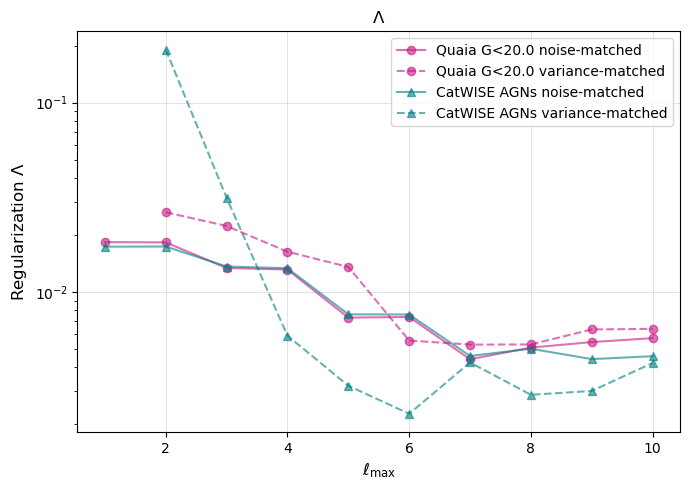

In [40]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(quaia_noise_matched_dict.keys(), quaia_noise_matched_dict.values(),
        c='mediumvioletred', alpha=0.6, marker='o', label='Quaia G<20.0 noise-matched')
ax.plot(quaia_var_matched_dict.keys(), quaia_var_matched_dict.values(),
        c='mediumvioletred', ls='--', alpha=0.6, marker='o', label='Quaia G<20.0 variance-matched')
ax.plot(catwise_noise_matched_dict.keys(), catwise_noise_matched_dict.values(),
        c='teal', alpha=0.6, marker='^', label='CatWISE AGNs noise-matched')
ax.plot(catwise_var_matched_dict.keys(), catwise_var_matched_dict.values(),
        c='teal', ls='--', alpha=0.6, marker='^', label='CatWISE AGNs variance-matched')
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'$\Lambda$')
ax.legend()

### angular power spectra with these $\Lambda$

In [31]:
max_ells = np.arange(6, 11)

In [32]:
ellss = []
Cells_quaia_noise_matched = []
Cells_quaia_var_matched = []
Cells_catwise_noise_matched = []
Cells_catwise_var_matched = []
for i, max_ell in enumerate(max_ells):
    print(max_ell, end='\r')
    # noise-matched
    ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_quaia,
                                                          Lambda=quaia_noise_matched_dict[max_ell],
                                                                           max_ell=max_ell, selfunc=selfunc_quaia)
    Cells_quaia_noise_matched.append(Cells_quaia[1:])
    ells, Cells_catwise = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_catwise,
                                                          Lambda=catwise_noise_matched_dict[max_ell],
                                                                             max_ell=max_ell, selfunc=selfunc_catwise)
    Cells_catwise_noise_matched.append(Cells_catwise[1:])
    # variance-matched
    ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_quaia,
                                                          Lambda=quaia_var_matched_dict[max_ell],
                                                                           max_ell=max_ell, selfunc=selfunc_quaia)
    Cells_quaia_var_matched.append(Cells_quaia[1:])
    ells, Cells_catwise = multipoles.compute_Cells_in_overdensity_map_Lambda(overdensity_map_catwise,
                                                          Lambda=catwise_var_matched_dict[max_ell],
                                                                             max_ell=max_ell, selfunc=selfunc_catwise)
    Cells_catwise_var_matched.append(Cells_catwise[1:])
    ellss.append(ells[1:])

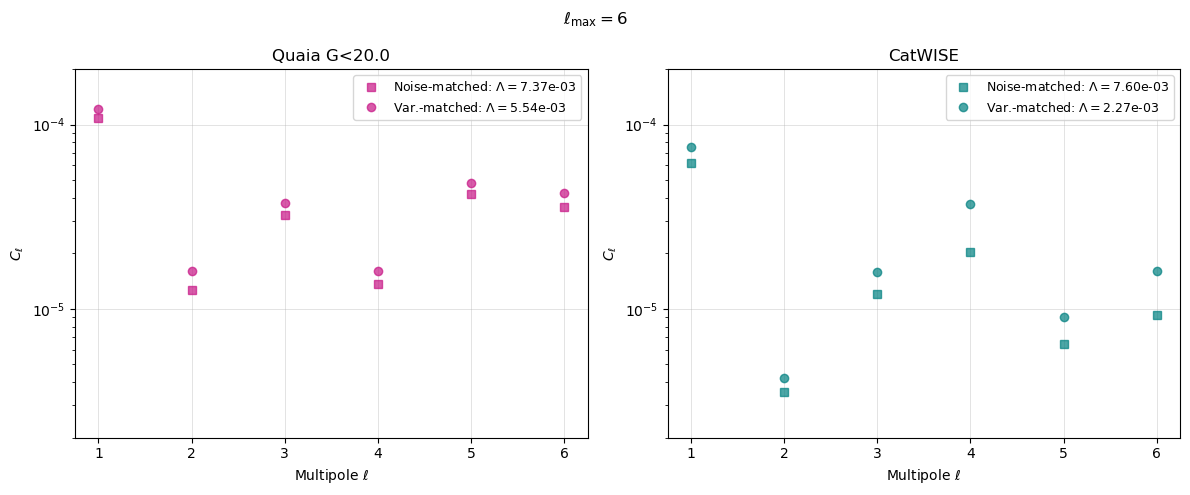

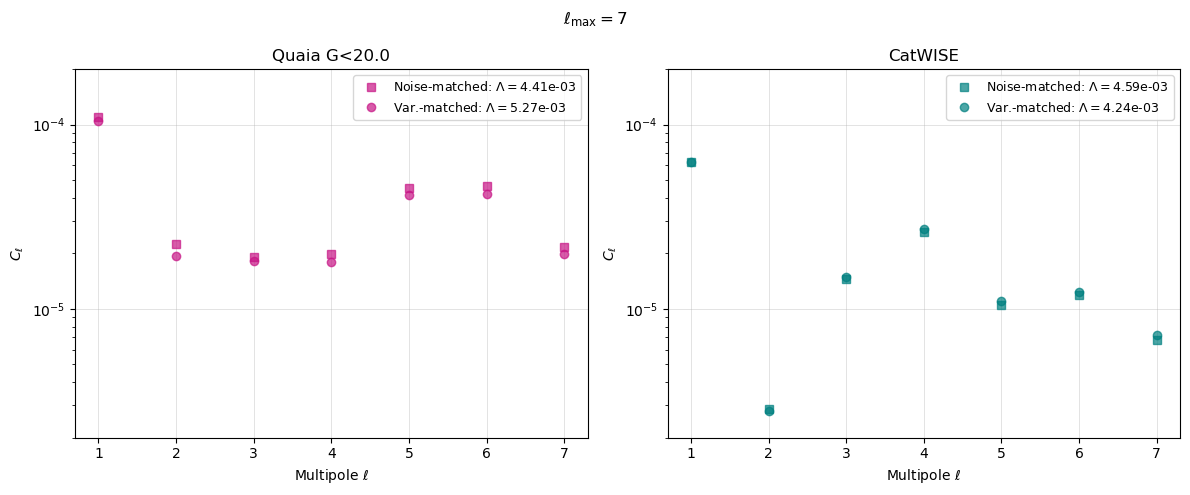

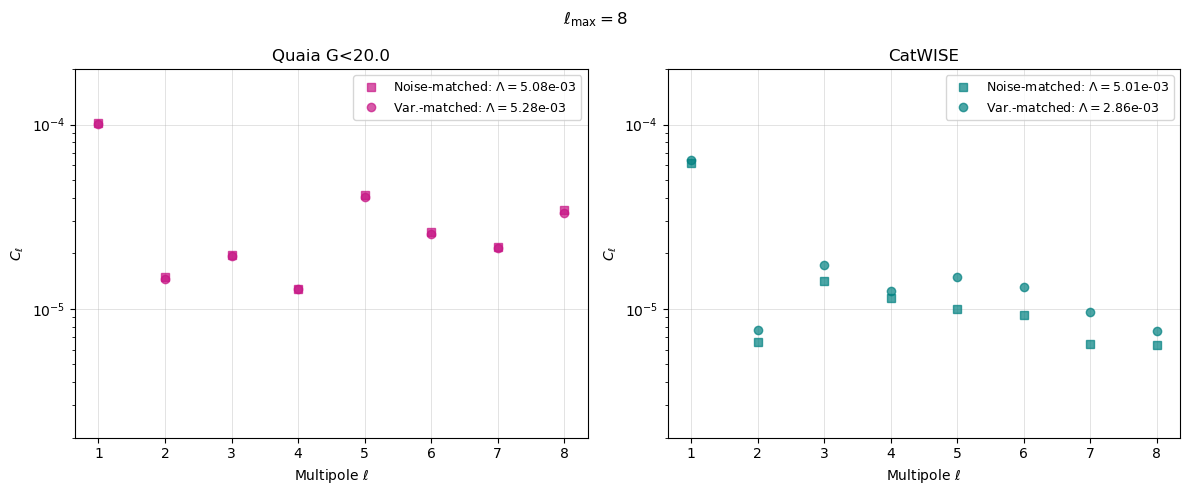

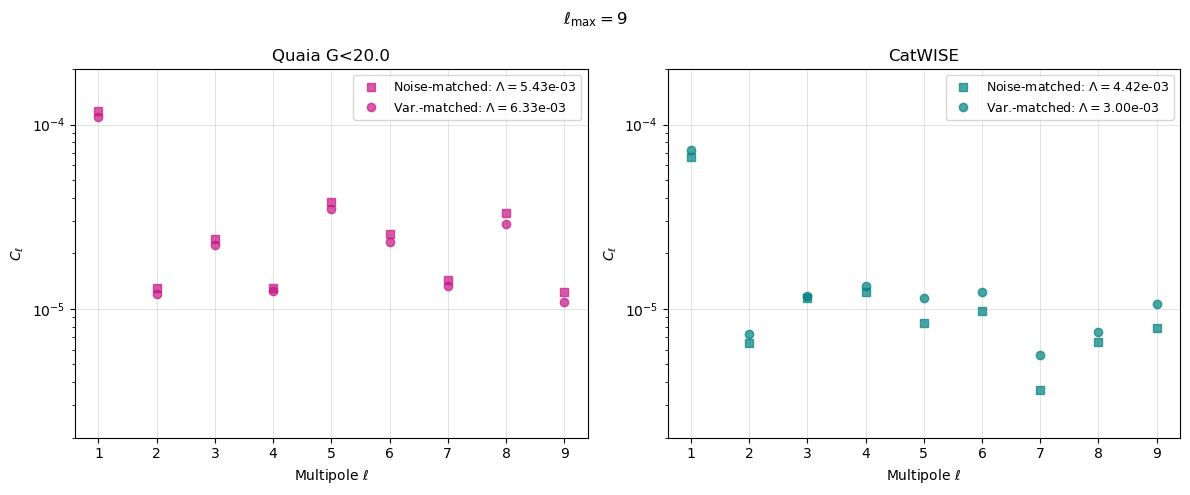

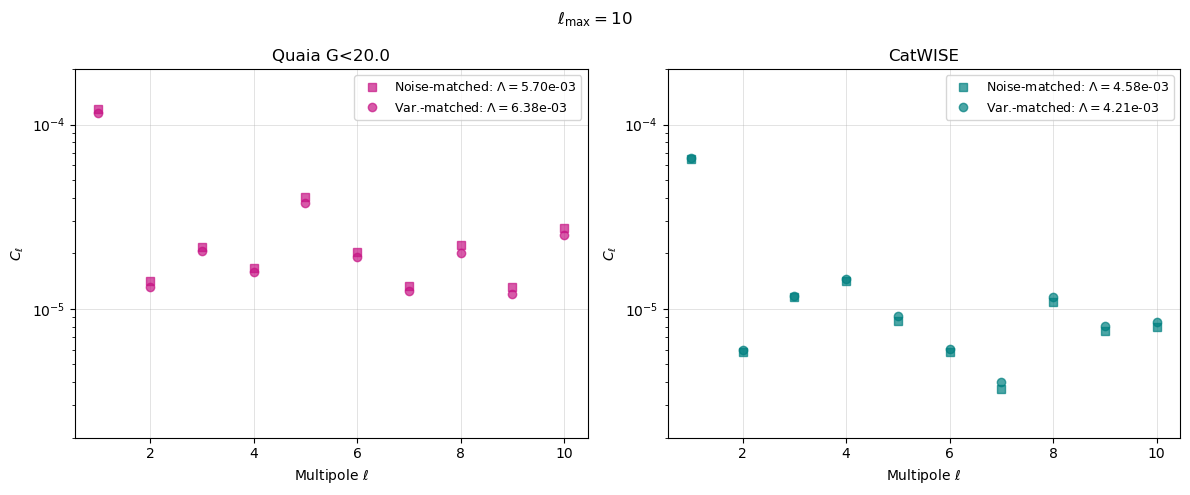

In [35]:
for i, max_ell in enumerate(max_ells):
    fig, axs = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)
    kwargs = dict(alpha=0.7, ls='None')
    axs[0].plot(ellss[i], Cells_quaia_noise_matched[i], marker='s', c='mediumvioletred',
            label=r'Noise-matched: $\Lambda=$'f'{quaia_noise_matched_dict[max_ell]:.2e}', **kwargs)
    axs[0].plot(ellss[i], Cells_quaia_var_matched[i], marker='o', c='mediumvioletred',
            label=r'Var.-matched: $\Lambda=$'f'{quaia_var_matched_dict[max_ell]:.2e}', **kwargs)
    axs[0].set_title('Quaia G<20.0')
    axs[1].plot(ellss[i], Cells_catwise_noise_matched[i], marker='s', c='teal',
            label=r'Noise-matched: $\Lambda=$'f'{catwise_noise_matched_dict[max_ell]:.2e}', **kwargs)
    axs[1].plot(ellss[i], Cells_catwise_var_matched[i], marker='o', c='teal',
            label=r'Var.-matched: $\Lambda=$'f'{catwise_var_matched_dict[max_ell]:.2e}', **kwargs)
    axs[1].set_title('CatWISE')
    for ax in axs:
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_ylim(2e-6, 2e-4)
        ax.semilogy()
        ax.set_xlabel(r'Multipole $\ell$')
        ax.set_ylabel(r'$C_\ell$')
        ax.legend(fontsize=9)
    fig.suptitle(r'$\ell_\mathrm{max}=$'f'{max_ell}')

In [41]:
# save these
for i, max_ell in enumerate(max_ells):
    save_dict = dict(Lambda=quaia_noise_matched_dict[max_ell], ells=ellss[i], Cells=Cells_quaia_noise_matched[i])
    np.save(f'/scratch/aew492/quasars/Cells/quaia/Cells_ellmax{max_ell}_Lambda_noise-matched.npy', save_dict)
    save_dict = dict(Lambda=quaia_var_matched_dict[max_ell], ells=ellss[i], Cells=Cells_quaia_var_matched[i])
    np.save(f'/scratch/aew492/quasars/Cells/quaia/Cells_ellmax{max_ell}_Lambda_variance-matched.npy', save_dict)
    save_dict = dict(Lambda=catwise_noise_matched_dict[max_ell], ells=ellss[i], Cells=Cells_catwise_noise_matched[i])
    np.save(f'/scratch/aew492/quasars/Cells/catwise_agns/Cells_ellmax{max_ell}_Lambda_noise-matched.npy', save_dict)
    save_dict = dict(Lambda=catwise_var_matched_dict[max_ell], ells=ellss[i], Cells=Cells_catwise_var_matched[i])
    np.save(f'/scratch/aew492/quasars/Cells/catwise_agns/Cells_ellmax{max_ell}_Lambda_variance-matched.npy', save_dict)